In [42]:
import numpy as np
from importlib import reload
import sys
import os
import pandas as pd

BASE_DIR = os.path.abspath("..")
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

import matplotlib.pyplot as plt

import Eigen.PowerMethod
reload(Eigen.PowerMethod)
from Eigen.PowerMethod import Opt_PWM


import utils.read_data 
reload(utils.read_data)
from utils.read_data import read_pages

import utils.draw_graph
reload(utils.draw_graph)
from utils.draw_graph import draw_graph



# First step

Into the cell below are called two functions:

1) the first function read the data from the dataset
2) the second function plots a random subweb to have a look to the dataset

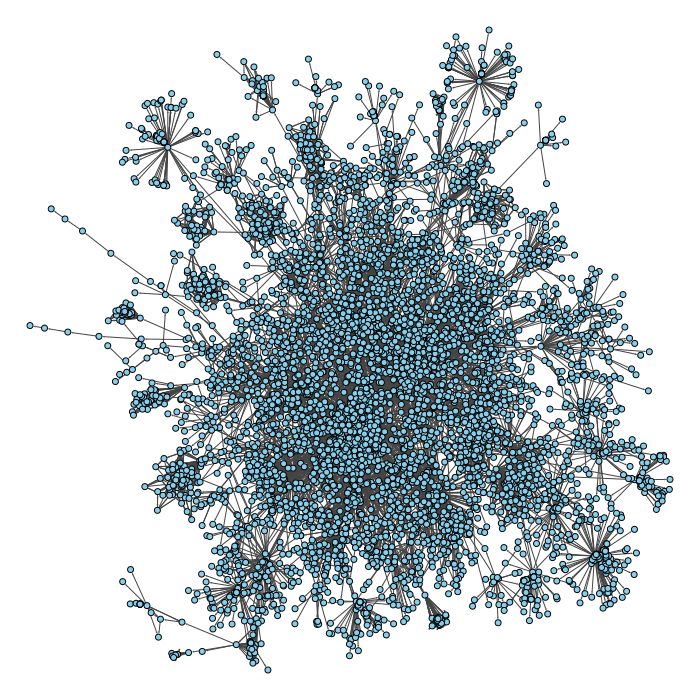

In [43]:
file_path = "DataSet/hollins.dat"
seed = 900
fig_size=(7,7)
lay = "fr"   # try "fr", "kk", "circle", "grid", "tree", lgl, auto, random, drl    best = fr


A,node_map,edges = read_pages(file_path)
n = A.shape[0]

sample_size = n

sampled_nodes, layout_cords  = draw_graph(A, sample_size=sample_size, seed = 9, fig_size=fig_size, lay = lay)

# Power method

In the cell below is applied the power method for computing the score 

The method stopped before k= 10000
number of iteration needed k= 498


value of c compared to |1-2*m/n|
0.9999667332002662
0.9999667332002662


/tmp/ipykernel_6058/2584408841.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


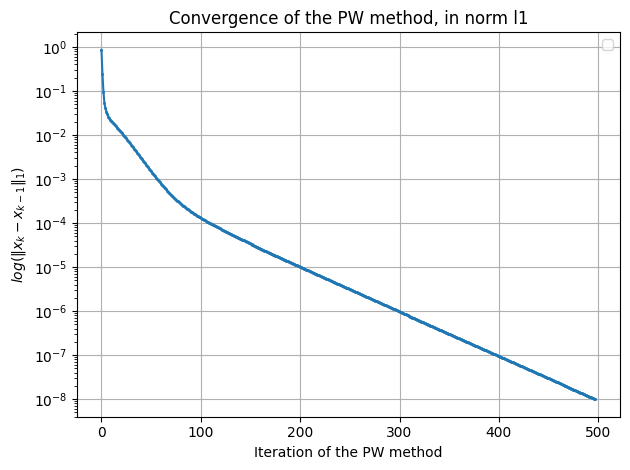

In [44]:
x_0 = np.ones((A.shape[0],1))
m = 0.1
#name = "error_with_m_099.png"
score,c,p,diff = Opt_PWM(A,m,x_0,k=10000)

print("number of iteration needed k=",p)
print("\n")
print("value of c compared to |1-2*m/n|")
print(c)
print(abs(1-2*m/n))  # I claim that max_i|1-2min_j M_ij| = |1-2*m/n|

plt.plot(range(0, p), diff, marker='s', markersize=1)
plt.xlabel("Iteration of the PW method")
plt.ylabel(r"$ log(\|x_k - x_{k-1}\|_1)$")
plt.title("Convergence of the PW method, in norm l1")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
#plt.savefig(name, format="png", dpi=300, bbox_inches="tight", pad_inches=0.3)
plt.show()

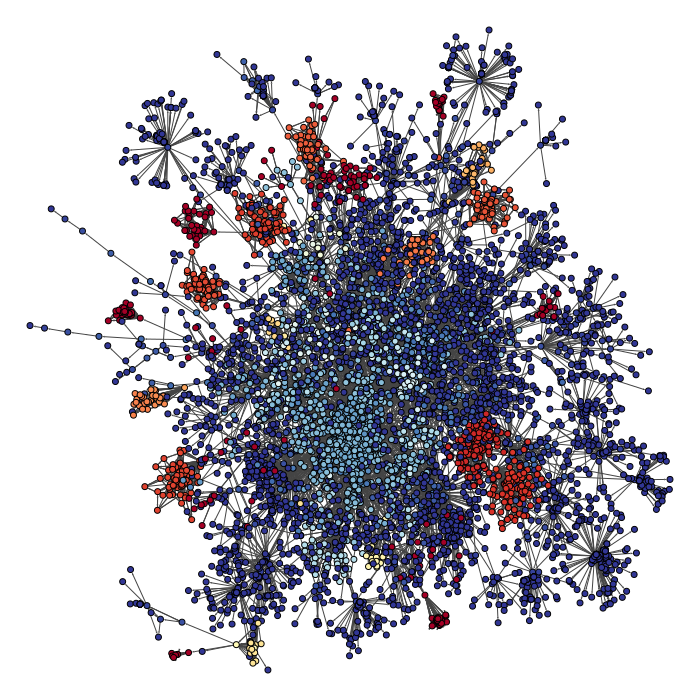

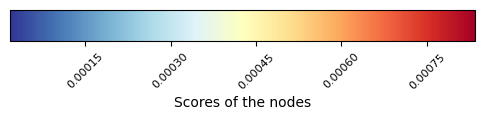

In [45]:
color_map = 'RdYlBu_r'
_,_ = draw_graph(A,sampled_nodes=sampled_nodes, sample_size=sample_size, seed = seed, values = score, cmap=color_map, fig_size=fig_size, lay = lay, layout_coords=layout_cords)

In [46]:
# forward and backlinks
out_deg = {}
in_deg = {}
backlinks = {}  

for src, dst in edges:
    out_deg[src] = out_deg.get(src, 0) + 1
    in_deg[dst] = in_deg.get(dst, 0) + 1
    backlinks.setdefault(dst, []).append(src)

#Table
data = []
for node_id, url in node_map.items():
    sc = score[node_id - 1][0] if node_id >= 1 and len(score) == max(node_map.keys()) else score[node_id]
    incoming = in_deg.get(node_id, 0)
    outcoming = out_deg.get(node_id, 0)

    # average score of the backlinks
    incoming_nodes = backlinks.get(node_id, [])
    if incoming_nodes:
        avg_backlink_score = sum(score[src - 1][0] if src >= 1 and len(score) == max(node_map.keys()) else score[src]
                                 for src in incoming_nodes) / len(incoming_nodes)
    else:
        avg_backlink_score = 0.0

    data.append((url, sc, incoming, outcoming, avg_backlink_score))

df = pd.DataFrame(data, columns=['page', 'score', 'backlinks', 'forwardlinks', 'Avg score of the backlink pages'])

# sorting
df = df.sort_values(by='score', ascending=False).reset_index(drop=True)

styled_df = (
    df.style
    .background_gradient(subset=['score','Avg score of the backlink pages'], cmap=color_map) 
    .set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center')]}]  
    ) 
    #.bar(subset=['backlinks', 'forwardlinks'], color='lightblue')
    .set_properties(**{'text-align': 'center'})
    .hide(axis='index')
)

display(styled_df)